In [1]:
! sudo apt-get update
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-extra cm-super

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [76.0 kB]
Hit:12 http://ppa.launchpad.net/cran/

In [2]:
import math

import matplotlib as mpl
mpl.rcParams['text.usetex'] = True 
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{libertine}', r'\RequirePackage[libertine]{newtxmath}'] 
mpl.rc('font', family='serif')

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import rc
from cycler import cycler

mpl.rcParams['ps.usedistiller'] = 'xpdf' 

plt.style.use('seaborn-notebook')

plt.rcParams['axes.titlesize'] = '25'
plt.rcParams['axes.labelsize'] = '25'
plt.rcParams['legend.fontsize'] = '15'
plt.rcParams['xtick.labelsize'] = '15'
plt.rcParams['ytick.labelsize'] = '15'

monochrome=(cycler('color', sns.color_palette("husl", 8))*2+(cycler('marker', ['v', 's', "o"])*7)[0:16])
plt.rc('axes', prop_cycle=monochrome)

pd.options.display.max_rows = 999

Setting rcParams['ps.usedistiller'] to 'xpdf' requires xpdf.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
masterdata_scala = pd.read_csv("/content/drive/MyDrive/GMCDE/experiments/power/GC3PowerM/2022-01-22-12-45_GC3PowerM_scala/GC3PowerM_scala.csv")
masterdata_python = pd.read_csv("/content/drive/MyDrive/GMCDE/experiments/power/GC3PowerM/2022-01-21-12-44_GC3PowerM_python/GC3PowerM_python.csv")

In [5]:
masterdata = masterdata_scala.append(masterdata_python)

In [6]:
masterdata["genId"] = [x.split("-")[1] for x in masterdata["genId"]]

In [7]:
masterdata.head(10)

,genId,dim,noise,obs_num,measure,avg_gc,std_gc,power90,power95,power99
0,l,6,0.00,1000,GMCDE,1.000000,0.000000,1.000,1.000,1.000
1,l,6,0.37,1000,GMCDE,0.898801,0.029057,1.000,1.000,1.000
2,l,6,0.83,1000,GMCDE,0.584300,0.053475,0.660,0.494,0.204
3,l,6,0.67,1000,GMCDE,0.645737,0.041867,0.984,0.924,0.638
4,l,6,0.60,1000,GMCDE,0.684439,0.041044,1.000,0.994,0.898
5,l,6,0.53,1000,GMCDE,0.731241,0.038197,1.000,1.000,0.992
6,l,6,0.87,1000,GMCDE,0.567641,0.050062,0.538,0.334,0.110
7,l,6,0.90,1000,GMCDE,0.561795,0.050213,0.490,0.312,0.080
8,l,6,0.77,1000,GMCDE,0.603743,0.048102,0.804,0.640,0.304
9,l,6,0.03,1000,GMCDE,1.000000,0.000000,1.000,1.000,1.000


In [8]:
masterdata["genId"].unique()

array(['l', 'hs', 'dl_0.25', 'cr', 'lp_2.0', 'st', 'si_1.0', 'ho',
       'si_5.0', 'zi', 'hc', 'i', 'hcg', 'gl_3.0'], dtype=object)

In [9]:
masterdata["measure"].unique()

array(['GMCDE', 'dHSIC'], dtype=object)

In [10]:
genIds = ['l','dl_0.25','lp_2.0','si_1.0', 'si_5.0','hc','hcg','hs','cr','st','ho','zi', 'i', 'gl_3.0']
genIds_no_benchmark = ['l','dl_0.25','lp_2.0','si_1.0', 'si_5.0','hc','hcg','hs','cr','st','ho','zi']

In [11]:
prettynames = {
    'si_5.0': "S5", 
    'si_1.0': "S1", 
    'hs': "Hs", 
    'st': "St", 
    'dl_0.25': "Dl", 
    'zi': "Zi", 
    'i': "U", 
    'hcg': "HcG", 
    'hc': "Hc", 
    'ho': "H", 
    'cr': "C",
    "l" : "L",
    "lp_2.0":"Lp",
    "gl_3.0": "GL"
}

In [46]:
def score_plot(selectedData, nDim):
  vars = ["GMCDE", "dHSIC"]
  var_name = "measure"
  avg = "avg_gc"
  std = "std_gc"

  num_vars = len(vars)
  num_genIds = len(genIds)
  fig, axes = plt.subplots(nrows=2, ncols=num_vars, figsize=(7*num_vars, 12), sharey=False, sharex=True)
  axess = axes.reshape(-1)
  fig.suptitle("Distribution of Scores assigned to 3 multivariate random variables \n" + r" $d = 3k$" + f"= {nDim}", fontsize = 36, y = 1.05)

  for i,var in enumerate(vars):
      subdata = selectedData[(selectedData[var_name] == var)  & (selectedData["dim"] == nDim)]
      d = subdata.groupby(["noise","genId"]).mean()[avg].reset_index()
      dd = d.set_index(["noise", "genId"]).unstack("noise")
      dd.columns = dd.columns.droplevel(0)
      dd = dd.reindex(genIds)
      dd = dd.rename(index={genId: prettynames[genId] for genId in genIds})
      
      ax = axess[i]

      if var == "GMCDE":
        axm = sns.heatmap(dd,  cmap=sns.color_palette("RdBu", 100), vmax=1,
                      xticklabels=[format(x, '.2f') for x in dd.columns.values.round(2)], 
                      ax=ax)
        cbar = axm.collections[0].colorbar
        cbar.ax.tick_params(labelsize=25)   
      if var == "dHSIC":
        axm = sns.heatmap(dd,  cmap=sns.color_palette("RdBu", 100),
                      xticklabels=[format(x, '.2f') for x in dd.columns.values.round(2)], 
                      ax=ax)
        cbar = axm.collections[0].colorbar
        cbar.ax.tick_params(labelsize=25)

      ax.set_yticklabels([r'\textbf{%s}'%x.get_text() for x in ax.get_yticklabels()], rotation=0, fontsize = 25)
      
      ax.set_title(r'%s'%(var), fontsize = 40)
      ax.set_ylabel("")
      
      sp = [""]*int(((len(ax.get_xticklabels())-6)/5))
      ax.set_xticklabels(["0"] + sp + ["0.2"] + sp + ["0.4"] + sp + ["0.6"] + sp + ["0.8"] + sp + ["1"])
      
      ax.set_xlabel("")
      if(i==0):
          ax.set_ylabel("Mean", fontsize = 40)
      else:
          ax.set_ylabel("")

  for i,var in enumerate(vars):
      subdata = selectedData[(selectedData[var_name] == var)  & (selectedData["dim"] == nDim)]
      d = subdata.groupby(["noise","genId"]).mean()[std].reset_index()
      dd = d.set_index(["noise", "genId"]).unstack("noise")
      dd.columns = dd.columns.droplevel(0)
      dd = dd.reindex(genIds)
      dd = dd.rename(index={genId: prettynames[genId] for genId in genIds})
      
      ax = axess[i+num_vars]
      
     
      axv = sns.heatmap(dd,  cmap=sns.color_palette("RdBu", 100),
              xticklabels=[format(x, '.2f') for x in dd.columns.values.round(2)], ax=ax)
      cbar = axv.collections[0].colorbar
      cbar.ax.tick_params(labelsize=25)
      
      ax.set_yticklabels([r'\textbf{%s}'%x.get_text() for x in ax.get_yticklabels()], rotation=0, fontsize = 25)
      
      ax.set_title("")
      ax.set_ylabel("")
      labels = ["" for x in range(0,31)]
      labels[0] = "0"
      labels[-1] = "1"
      labels[int(len(labels)/2)] = r'$\leftarrow \sigma \rightarrow $'
      ax.set_xticklabels(labels, rotation = 0, fontsize = 25)
      ax.set_xlabel('')
      
      if(i==0):
          ax.set_ylabel("Standard Deviation", fontsize = 40)
      else:
          ax.set_ylabel("")

  plt.tight_layout()
  plt.savefig(f"score_gc_{nDim}", bbox_inches='tight')

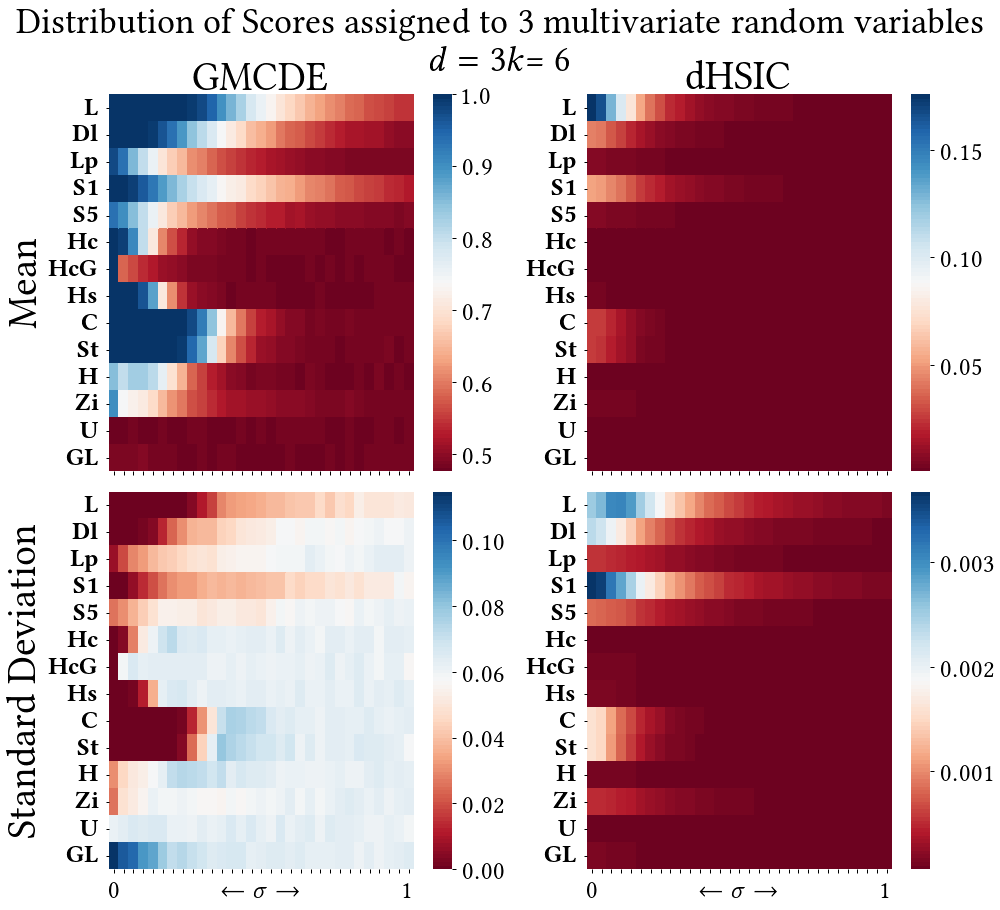

In [47]:
score_plot(masterdata, 6)

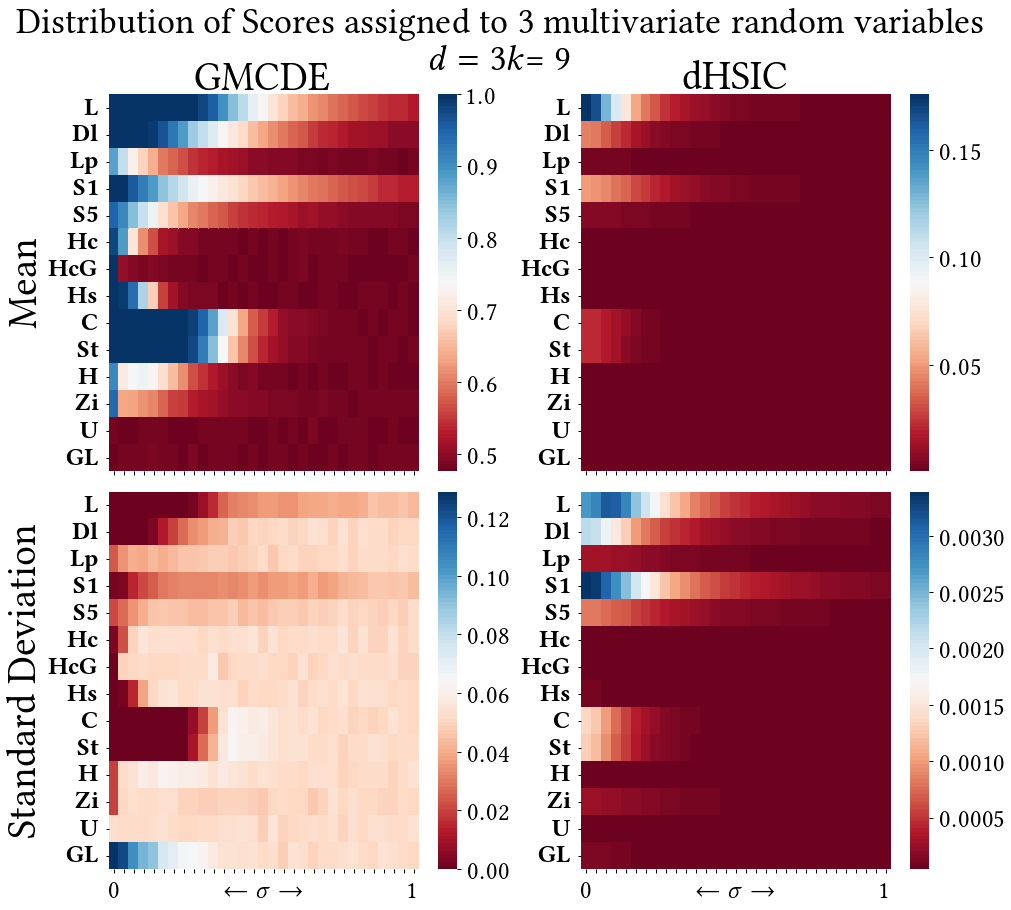

In [48]:
score_plot(masterdata, 9)

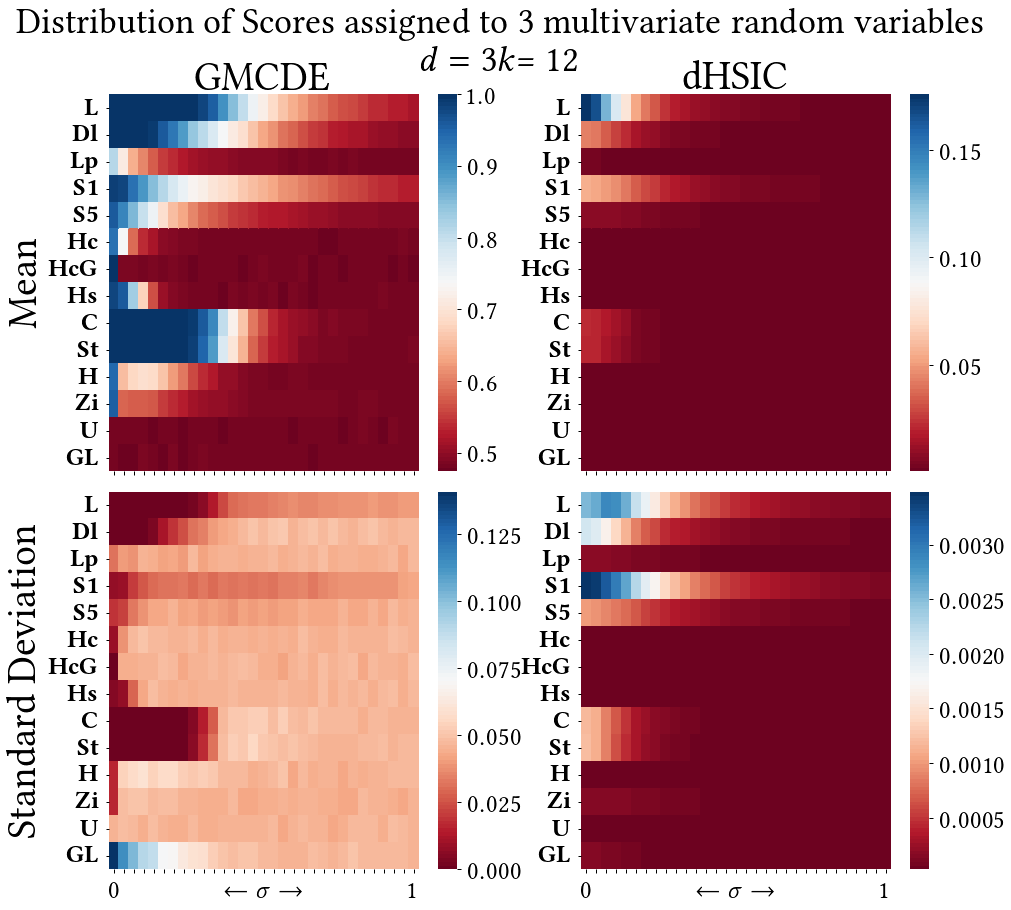

In [49]:
score_plot(masterdata, 12)

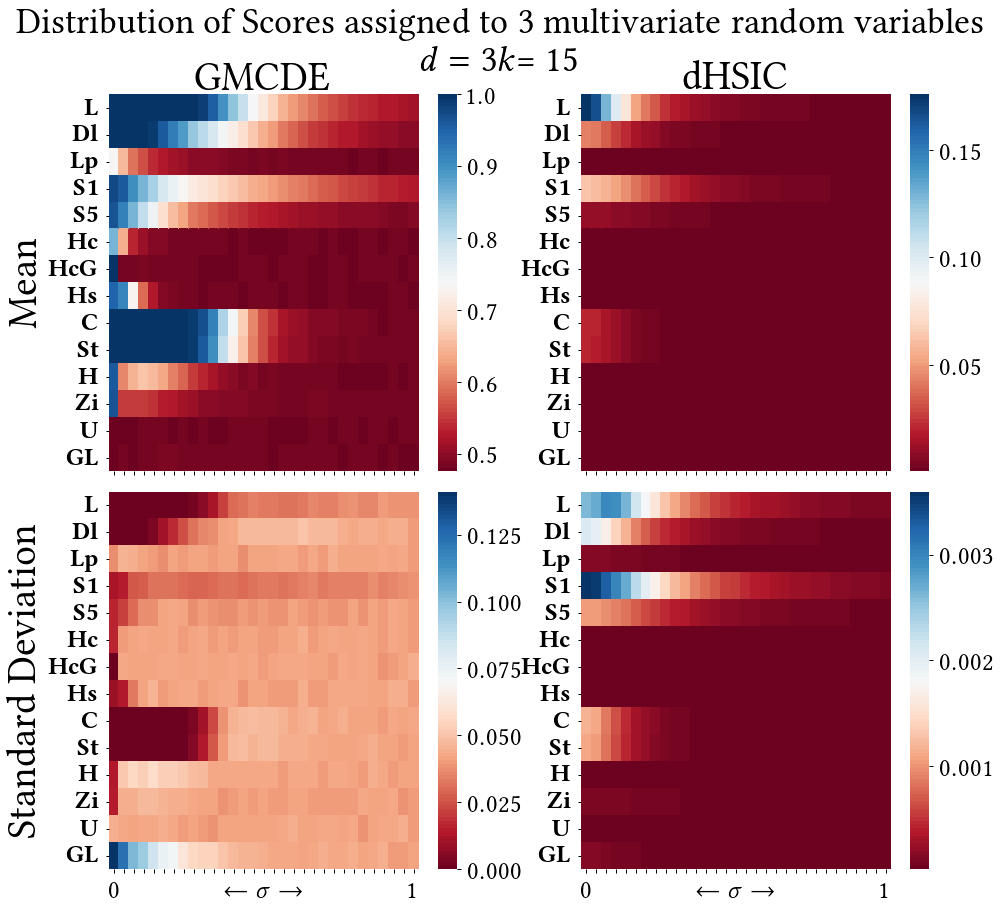

In [50]:
score_plot(masterdata, 15)

In [34]:
def power_plot(masterdata):
  %matplotlib inline
  measure = "power95"
  variable = "measure"
  vars = ['GMCDE','dHSIC']
  num_vars = len(vars)
  num_genIds = len(genIds_no_benchmark)
  fig, axes = plt.subplots(nrows=num_genIds, ncols=num_vars, figsize=(7*num_vars, 1.8*num_genIds), sharey=True, sharex=True)
  fig.suptitle(r"Power of different measures for 3 multivariate random variables, $d = 3k$", fontsize = 35, y = 1.03)
  axess = axes.reshape(-1)
  cbar_ax1 = fig.add_axes([1.02, 0.03, .01, 0.94])
  cbar_ax1.tick_params(labelsize=40)
  yticklabels = [f"{k}-d" for k in range(4,17,4)]

  i = 0
  for genId in genIds_no_benchmark:
      for var in vars:
          ax = axess[i]
          subdata = masterdata[(masterdata[variable] == var) & (masterdata["genId"] == genId)]
          d = subdata.groupby(["noise","dim"]).mean()[measure].reset_index()
          dd = d.set_index(["noise", "dim"]).unstack("noise")
          dd.columns = dd.columns.droplevel(0)

          plt.sca(axess[i])
          
          axp = sns.heatmap(dd, vmin=0.0, vmax=1.0, cmap=sns.color_palette("RdBu", 100), ax = ax, 
                          xticklabels=3,
                          cbar=True,
                        cbar_ax=cbar_ax1,
                        linewidths=0.01,
                        linecolor='grey',
                        )
          
          axp.set_yticklabels(yticklabels, fontsize = 16, rotation = 0)
          
          if(i < len(vars)):
              plt.title(var, fontsize = 40)
          
          if((i % len(vars)) == 0):
              plt.ylabel(prettynames[genId],  rotation=0, labelpad=40, fontsize = 40)
              #ax.set_yticklabels(ax.get_yticklabels(),  rotation=0)
          else:
              plt.ylabel("")
              
          labels = ["" for x in range(0,11)]
          labels[0] = "0"
          labels[-1] = "1"
          labels[5] = r"$\sigma$"
          labels[3] = r"$\leftarrow$"
          labels[7] = r"$\rightarrow$"
          
          ax.set_xticklabels(labels,  rotation=0, fontsize = 25)
          
          ax.set_xlabel('', labelpad=0)
          i = i+1
  plt.tight_layout()
  plt.savefig("power_compare_3", bbox_inches='tight')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


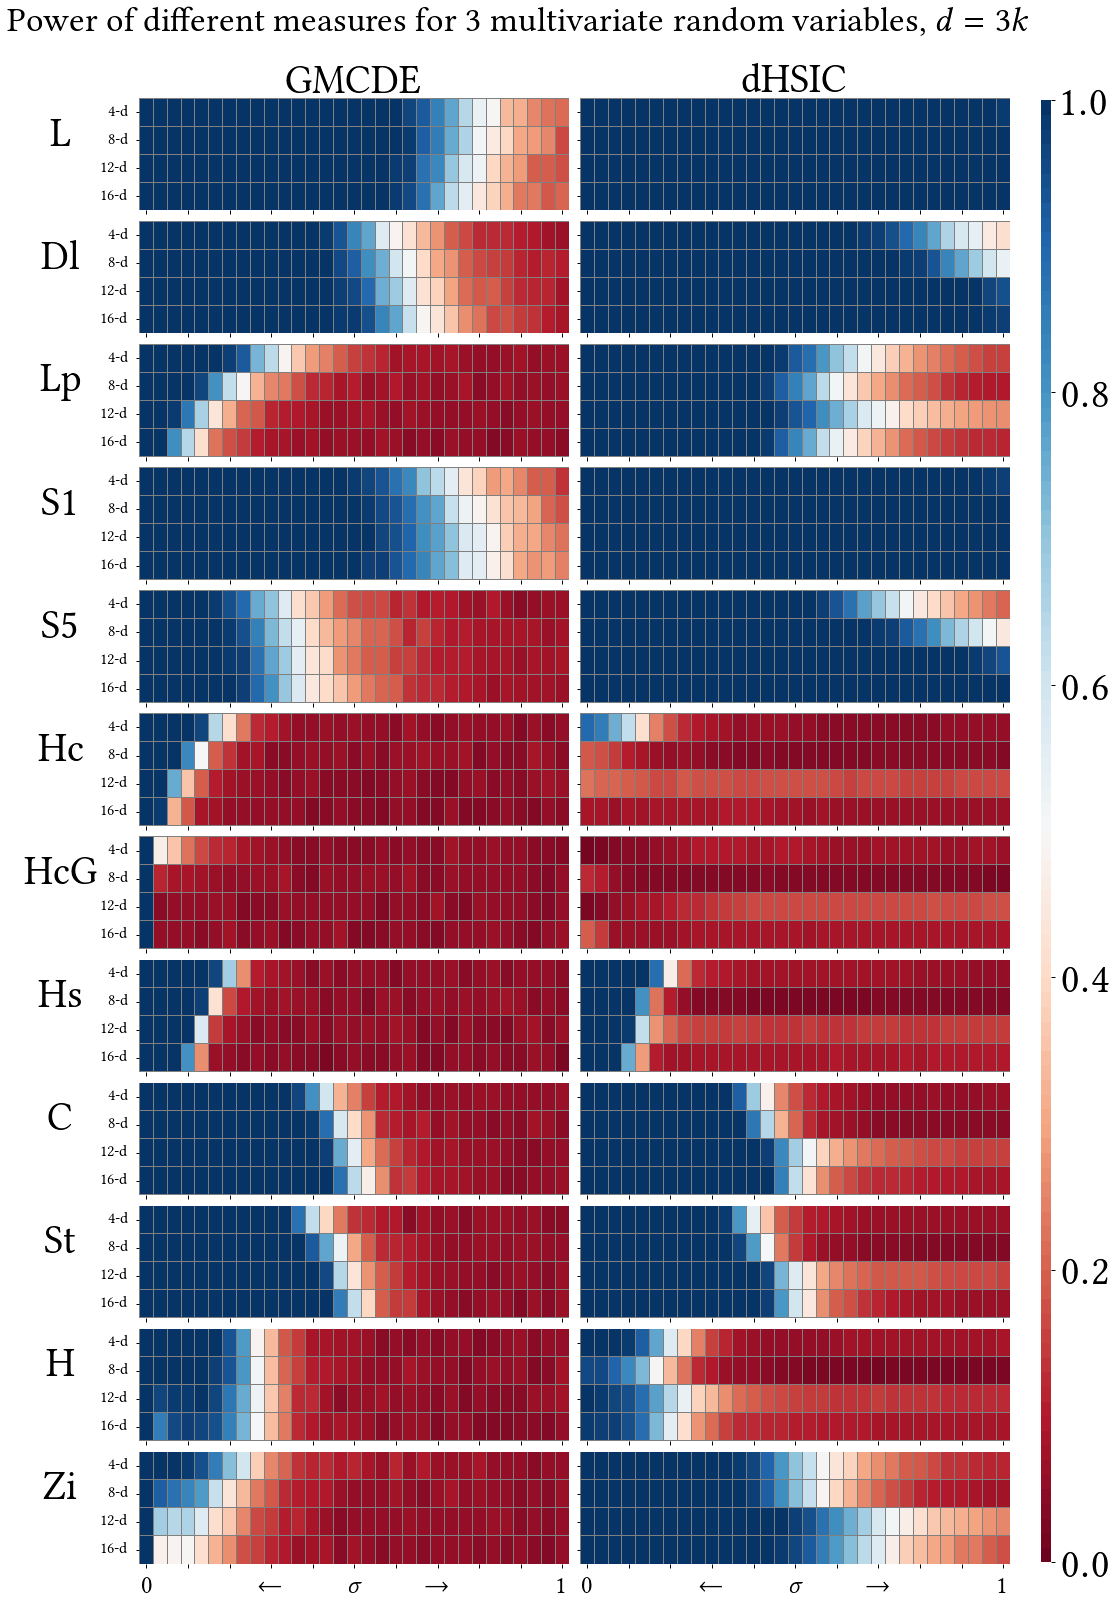

In [18]:
power_plot(masterdata)